## Testing hypothesis 2
---

**_Hypothesis_**: Reviews with more positive sentiment words receive higher helpfulness ratings.

- **Metric**: Mean helpfulness ratings for number of positive and negative words.

- **Model**: Multinomial Naive Bayes.

- **Description**:

  - Use NBC as a classifier to predict the sentiment of a review.
  - Extract the most useful words from the classifier.
  - Compute the mean helpfulness ratings for the most useful words.

**Missing Values**:

  - `review/score`: remove the entire sample
  - `review/text`: remove the entire sample
  - `review/helpfulness`: remove the entire sample

**Data Transformation**:

  - `review/score`: Assign 1 to score (4, 5), 0 to score (1, 2).
  - `review/text`: Create the BoW for the text. Fit a MNBC and count the number of positive and negative words. Graphical Plot.
  - `review/helpfulness`: $helpfulness = \frac{x}{y} \sqrt(y)$

---

In [10]:
# Import libraries
import nltk
nltk.download('stopwords')
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

[nltk_data] Downloading package stopwords to /home/hdoop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Initialize spark
import findspark
findspark.init()

# Initialize SparkSession
spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "4g").appName("hypothesis_2").getOrCreate()

# Define the schema
ratings_schema = StructType([
    StructField("Title", StringType(), True),
    StructField("Price", FloatType(), True),
    StructField("User_id", IntegerType(), True),
    StructField("profileName", StringType(), True),
    StructField("review/score", FloatType(), True),
    StructField("review/time", IntegerType(), True),
    StructField("review/summary", StringType(), True),
    StructField("review/text", StringType(), True),
    StructField("N_helpful", IntegerType(), True),
    StructField("Tot_votes", IntegerType(), True)
])

# Load your DataFrame (assuming you have it in a variable df)
# Load the data
df_ratings = spark.read.csv('hdfs://localhost:9900/user/book_reviews/books_rating_cleaned.csv', header=True, schema=ratings_schema, sep='\t')
df_ratings.show(5)

#random select 5000 rows of df_ratings
df_ratings = df_ratings.sample(withReplacement = False, fraction = 5000/df_ratings.count(), seed = 42)

+--------------------+-----+-------+--------------------+------------+-----------+--------------------+--------------------+---------+---------+
|               Title|Price|User_id|         profileName|review/score|review/time|      review/summary|         review/text|N_helpful|Tot_votes|
+--------------------+-----+-------+--------------------+------------+-----------+--------------------+--------------------+---------+---------+
|Its Only Art If I...| null|   null|Jim of Oz  jim-of-oz|         4.0|  940636800|Nice collection o...|This is only for ...|        7|        7|
|Dr. Seuss: Americ...| null|   null|       Kevin Killian|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|       10|       10|
|Dr. Seuss: Americ...| null|   null|        John Granger|         5.0| 1078790400|Essential for eve...|If people become ...|       10|       11|
|Dr. Seuss: Americ...| null|   null|Roy E. Perry  ama...|         4.0| 1090713600|Phlip Nel gives s...|Theodore Seuss Ge...|      

In [12]:
# Filter out the data
df_ratings_filtered = df_ratings.filter(df_ratings['review/text'].isNotNull())
df_ratings_filtered = df_ratings_filtered.filter(df_ratings_filtered['review/score'] != 3)
df_ratings_filtered = df_ratings_filtered.filter(df_ratings_filtered['Tot_votes'] != 0)

# Remove punctuation and convert to lowercase the review/text column
df_ratings_filtered = df_ratings_filtered.withColumn('review/text', lower(regexp_replace('review/text', r'[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]', ' ')))
df_ratings_filtered.show(5)

# remove words with length less than 2
df_ratings_filtered = df_ratings_filtered.withColumn('review/text', regexp_replace('review/text', r'\b\w{1,2}\b', ' '))

# Add the helpfulness ratio column
df_ratings_filtered = df_ratings_filtered.withColumn('helpfulness_ratio', df_ratings_filtered['N_helpful']/df_ratings_filtered['Tot_votes']*sqrt(df_ratings_filtered['Tot_votes']))

# Add the class column
df_ratings_filtered = df_ratings_filtered.withColumn('class', when(df_ratings_filtered['review/score'] >= 4, 1).otherwise(0))

# Retain only the required columns
df_ratings_selected = df_ratings_filtered.select('review/text', 'helpfulness_ratio', 'class')
df_ratings_selected.show(5)

# Select relevant columns and handle missing values
df = df_ratings_selected.select("class", "helpfulness_ratio", "review/text").na.drop()
df.show(5)

# Tokenize the 'review/text' column
tokenizer = Tokenizer(inputCol="review/text", outputCol="words")

# Remove stopwords
stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

+--------------------+-----+-------+--------------------+------------+-----------+--------------------+--------------------+---------+---------+
|               Title|Price|User_id|         profileName|review/score|review/time|      review/summary|         review/text|N_helpful|Tot_votes|
+--------------------+-----+-------+--------------------+------------+-----------+--------------------+--------------------+---------+---------+
|      Edge of Danger| null|   null|       MKF  marilynf|         1.0| 1023148800|Edge of Danger by...|i was a big fan o...|        1|        1|
|Raising Gifted Ki...|10.71|   null|       A. C. Johnson|         2.0| 1330041600|Overly Alarmist T...|raising gifted ki...|        1|        1|
|The complete guid...| null|   null|      Empire Builder|         2.0| 1203033600|17 years old and ...|well  i might hav...|        5|        5|
|  Mothman Prophecies| null|   null|                null|         5.0| 1016236800|They're all diffe...|if you want to re...|      

In [13]:
# Convert words to a BoW feature vector
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

# Create a Naive Bayes model
nb = NaiveBayes(labelCol="class", featuresCol="features", predictionCol="prediction")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, stop_words_remover, vectorizer, nb])

# Fit the pipeline on your data
model = pipeline.fit(df)

# Fit the Multinomial Naive Bayes model on the training data
nb_model = model.stages[-1]

In [14]:
# Get the vocabulary
vocabulary = model.stages[2].vocabulary

# Get the word probabilities for class 1
class_1_probs = nb_model.theta.toArray()[1]

# Create a DataFrame of words and probabilities
import pandas as pd
results = pd.DataFrame({'word': vocabulary, 'prob': class_1_probs})

# Calculate the difference in word probabilities between class 1 and class 0
class_0_probs = nb_model.theta.toArray()[0]
class_1_probs = nb_model.theta.toArray()[1]
pos_neg_ratio = class_1_probs - class_0_probs

# Create a DataFrame with words and their positive-to-negative probability ratio
results = pd.DataFrame({'word': vocabulary, 'pos_neg_ratio': pos_neg_ratio})

# Sort the DataFrame in descending order of 'pos_neg_ratio'
positive_words = results.sort_values(by='pos_neg_ratio', ascending=False)

# Get the top N most positive words (e.g., top 10)
top_positive_words = positive_words.head(800)  # Change 10 to the desired number of words you want to see

# Display the top positive words
print(top_positive_words)

# Get the top N most negative words (e.g., top 10)
top_negative_words = positive_words.tail(800)  # Change 10 to the desired number of words you want to see

# Display the top negative words
print(top_negative_words)

# Convert top_positive_words to a list
top_positive_words = top_positive_words['word'].tolist()

              word  pos_neg_ratio
450        journey       3.127615
916     remarkable       2.504148
979           east       2.424105
470        england       2.381546
1069  contemporary       2.337094
...            ...            ...
4185    occupation       0.950800
4178          kiss       0.950800
4184         kesey       0.950800
3971          laci       0.950800
3972     mountains       0.950800

[800 rows x 2 columns]
               word  pos_neg_ratio
7992         jinnah      -2.140243
19483     recreated      -2.140243
27391  vociferously      -2.140243
16001   culturalist      -2.140243
7999        swallow      -2.140243
...             ...            ...
5164       hinduism      -3.644320
4580        shermer      -3.749681
3691      seagraves      -3.932002
1759        artemis      -4.012045
3455           fowl      -4.012045

[800 rows x 2 columns]


In [15]:
# Tokenize the review/text column into words
words_df = df.withColumn("words", split(col("review/text"), "\\s+"))
words_df.show(5)

#create a pyspark list with the occurrences of the top 20 words in each review
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def count_words(words):
    return len([word for word in words if word in top_positive_words])

count_words_udf = udf(count_words, IntegerType())
words_df = words_df.withColumn("count", count_words_udf(col("words")))
words_df.show(5)

+-----+------------------+--------------------+--------------------+
|class| helpfulness_ratio|         review/text|               words|
+-----+------------------+--------------------+--------------------+
|    0|               1.0|  was   big fan  ...|[, was, big, fan,...|
|    0|               1.0|raising gifted ki...|[raising, gifted,...|
|    0|  2.23606797749979|well    might hav...|[well, might, hav...|
|    1|4.2485291572496005|  you want   read...|[, you, want, rea...|
|    1|1.4142135623730951|water street     ...|[water, street, c...|
+-----+------------------+--------------------+--------------------+
only showing top 5 rows

+-----+------------------+--------------------+--------------------+-----+
|class| helpfulness_ratio|         review/text|               words|count|
+-----+------------------+--------------------+--------------------+-----+
|    0|               1.0|  was   big fan  ...|[, was, big, fan,...|    0|
|    0|               1.0|raising gifted ki...|[raisin

In [16]:
# calculate and print the correlation between the count and the helpfulness ratio
from pyspark.sql.functions import corr
words_df.select(corr("count", "helpfulness_ratio")).show()

+------------------------------+
|corr(count, helpfulness_ratio)|
+------------------------------+
|           0.17307626155710093|
+------------------------------+



+-----+------------------+--------------------+--------------------+-----+
|class| helpfulness_ratio|         review/text|               words|count|
+-----+------------------+--------------------+--------------------+-----+
|    0|               1.0|  was   big fan  ...|[, was, big, fan,...|    0|
|    0|               1.0|raising gifted ki...|[raising, gifted,...|    2|
|    0|  2.23606797749979|well    might hav...|[well, might, hav...|    2|
|    1|4.2485291572496005|  you want   read...|[, you, want, rea...|    7|
|    1|1.4142135623730951|water street     ...|[water, street, c...|    5|
+-----+------------------+--------------------+--------------------+-----+
only showing top 5 rows



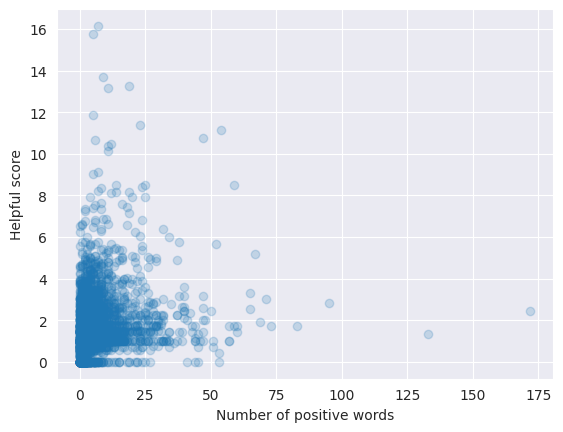

/home/hdoop/.virtualenvs/PyProject/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hdoop/.virtualenvs/PyProject/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Group number: 10
Correlation Coefficient: 0.11861197599913771
P-value: 2.440478338049092e-13



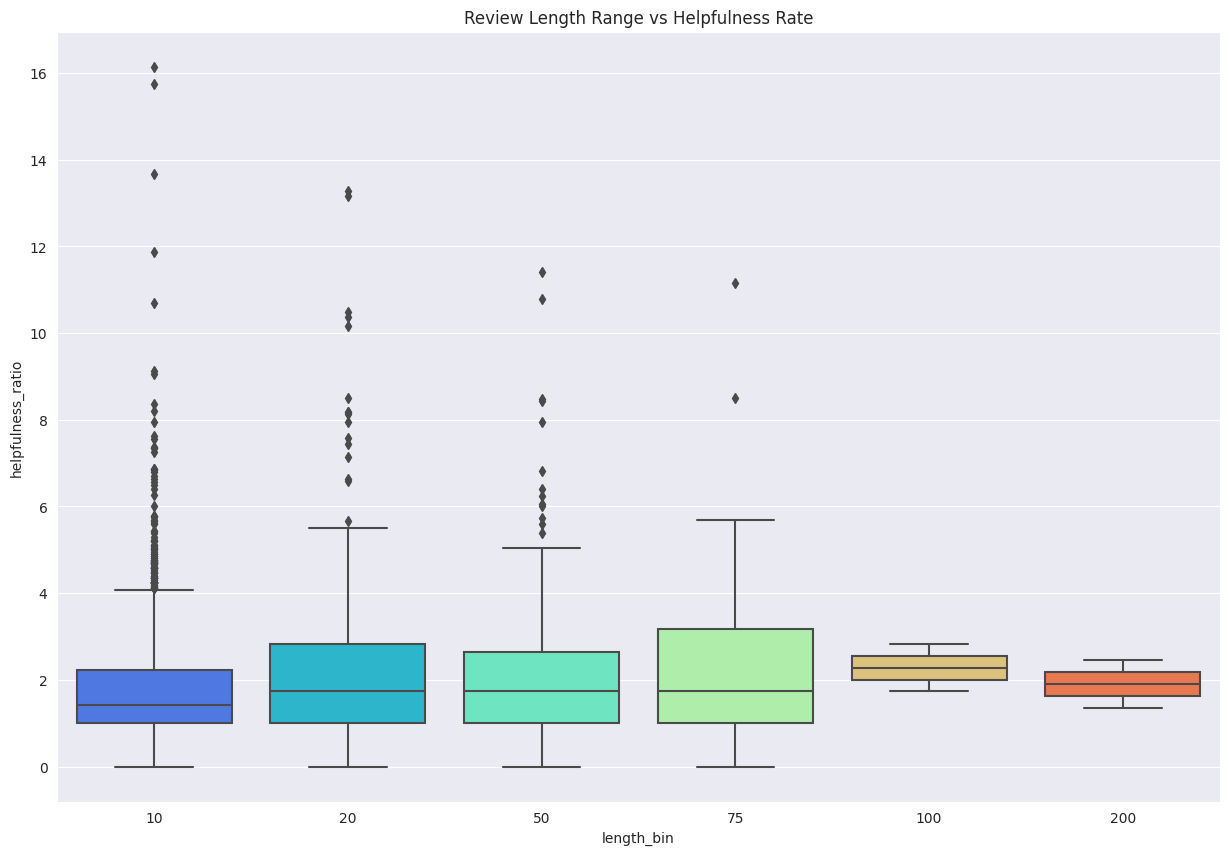

<Figure size 1500x1000 with 0 Axes>

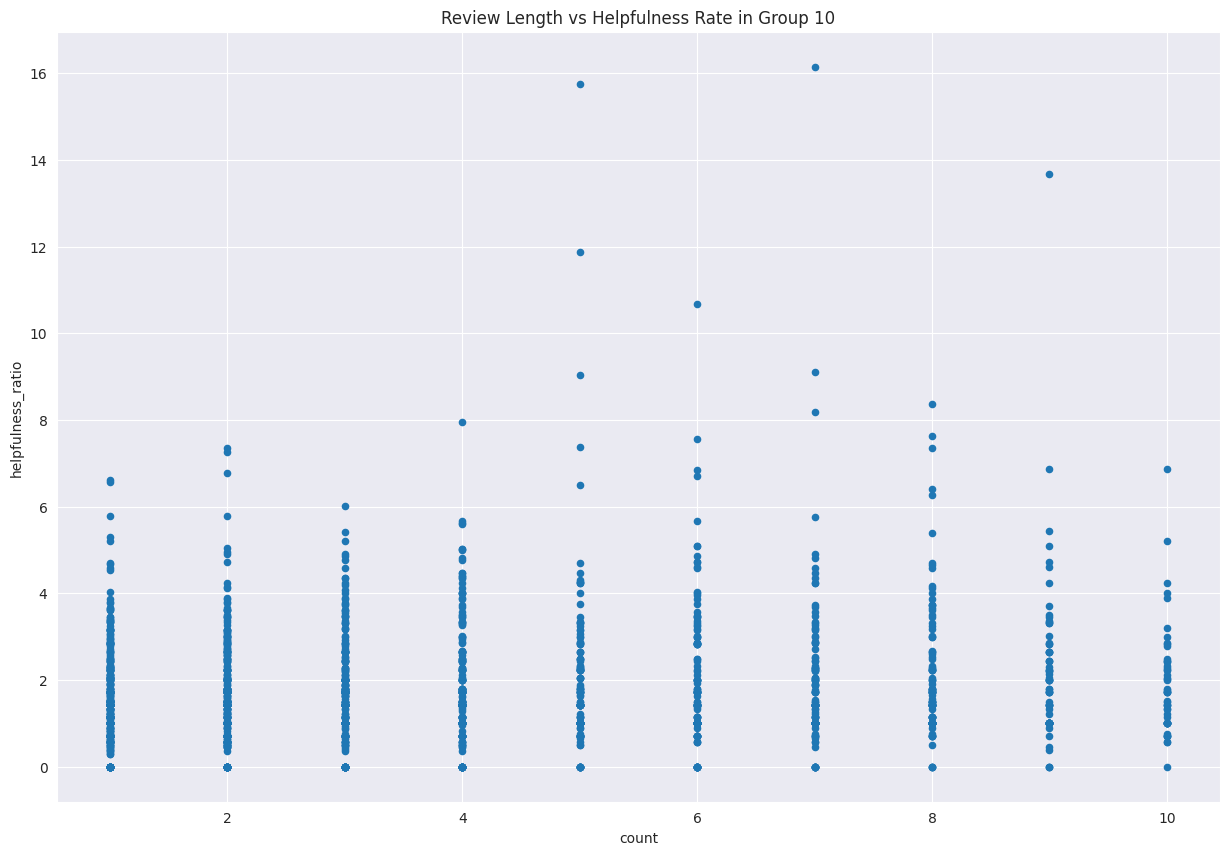

Group number: 20
Correlation Coefficient: -0.01497240212449187
P-value: 0.7113698152022916



<Figure size 1500x1000 with 0 Axes>

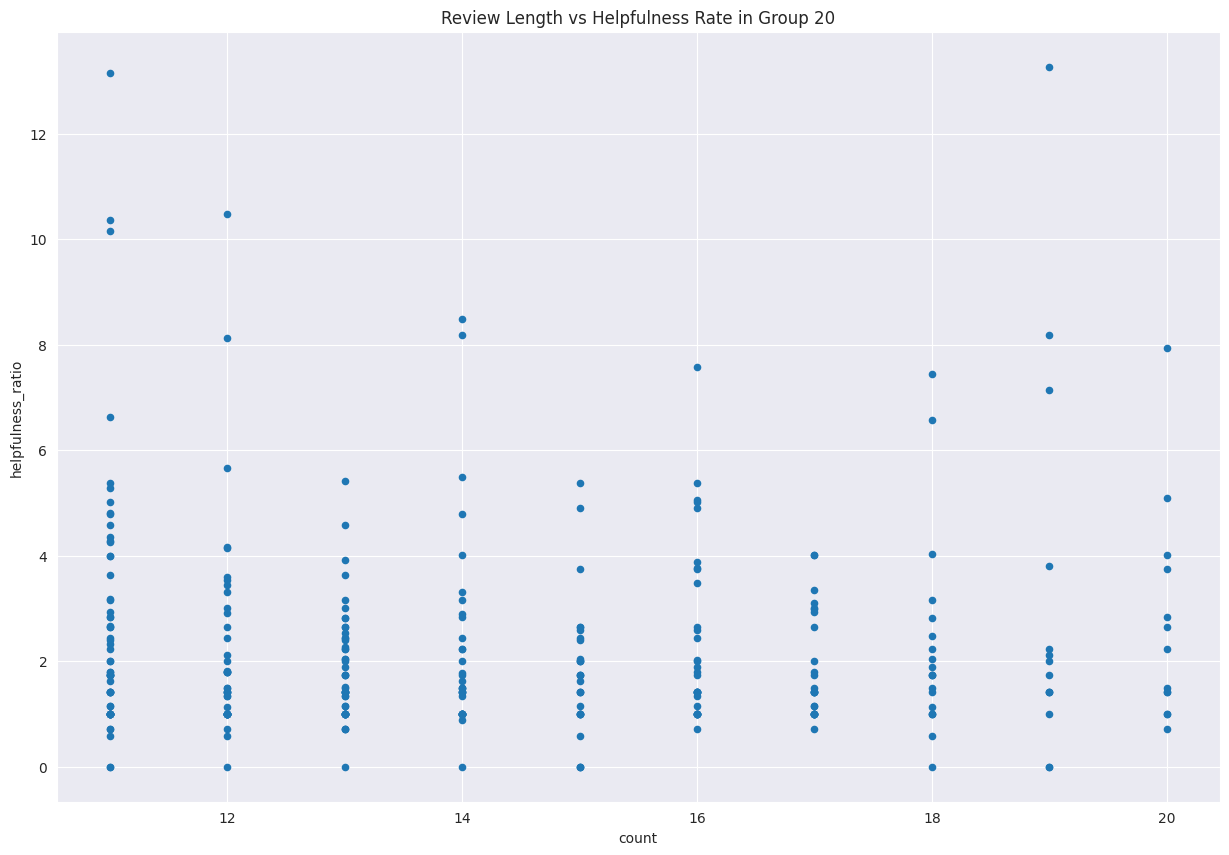

Group number: 50
Correlation Coefficient: -0.052431029015968515
P-value: 0.309300513117289



<Figure size 1500x1000 with 0 Axes>

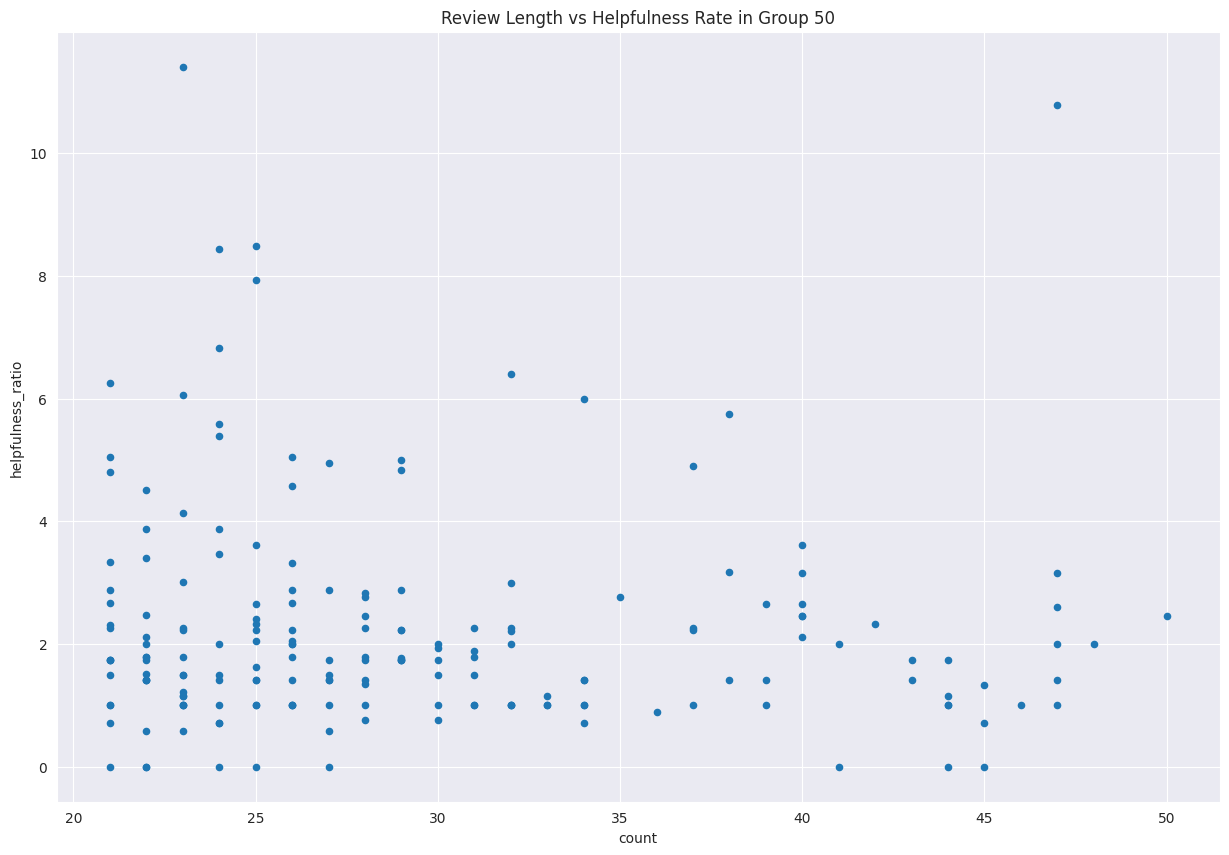

Group number: 75
Correlation Coefficient: 0.32615539008834116
P-value: 0.060376445786348994



<Figure size 1500x1000 with 0 Axes>

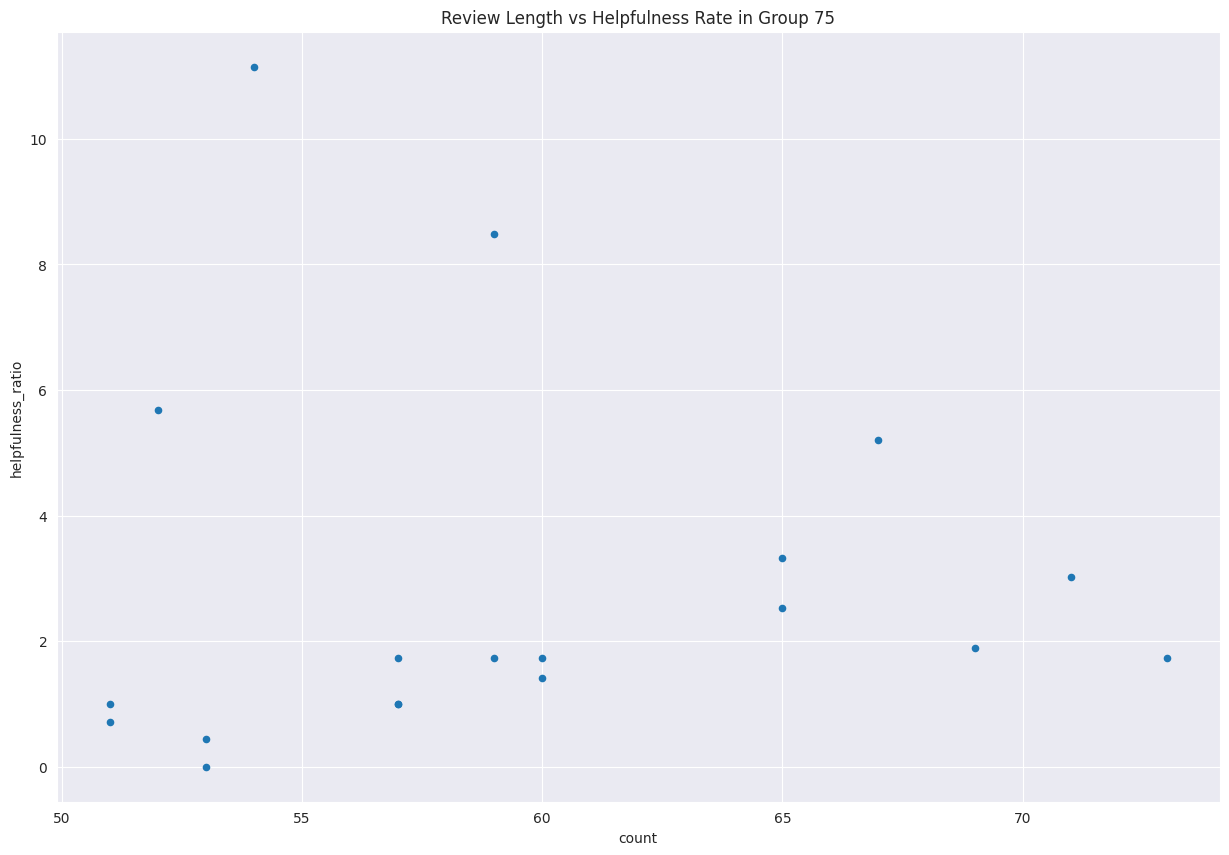

Group number: 100
Correlation Coefficient: 1.0
P-value: 1.0



<Figure size 1500x1000 with 0 Axes>

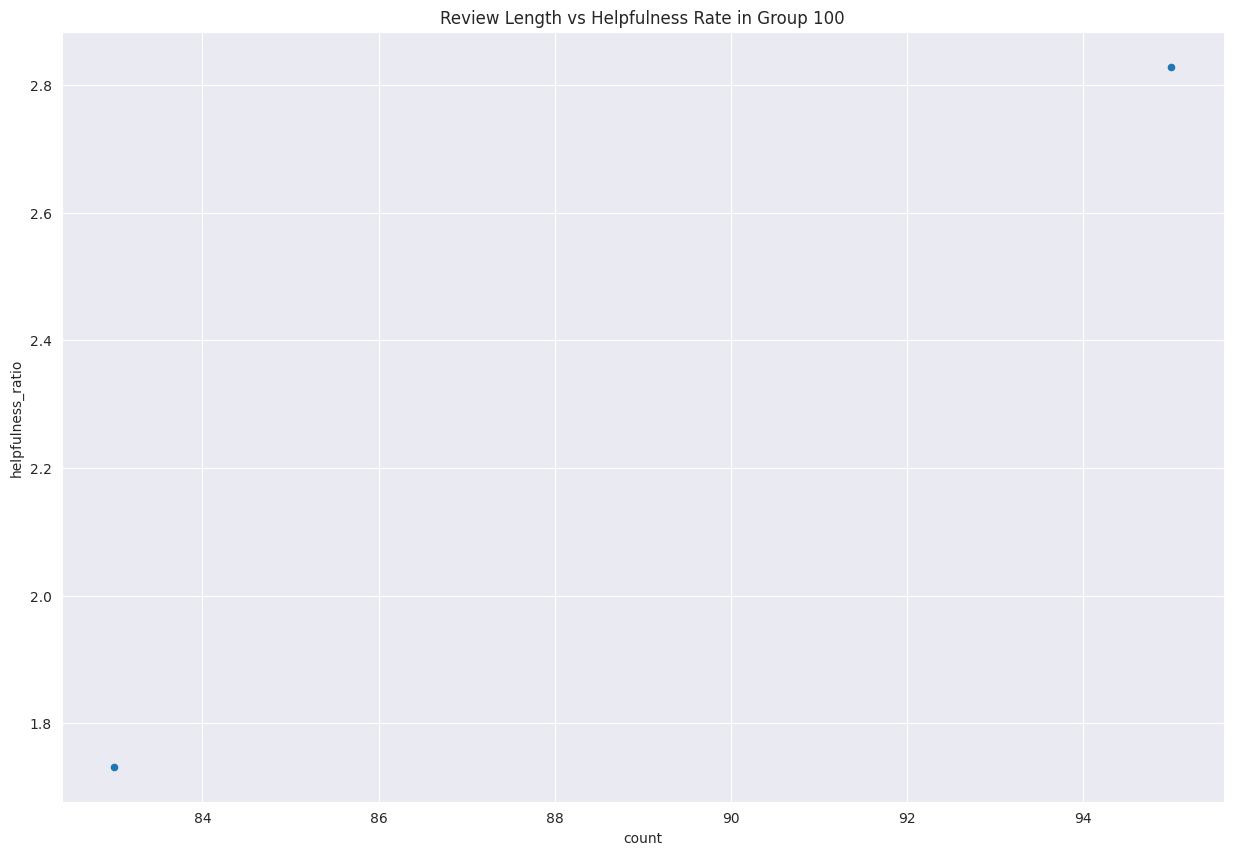

Group number: 200
Correlation Coefficient: 1.0
P-value: 1.0



<Figure size 1500x1000 with 0 Axes>

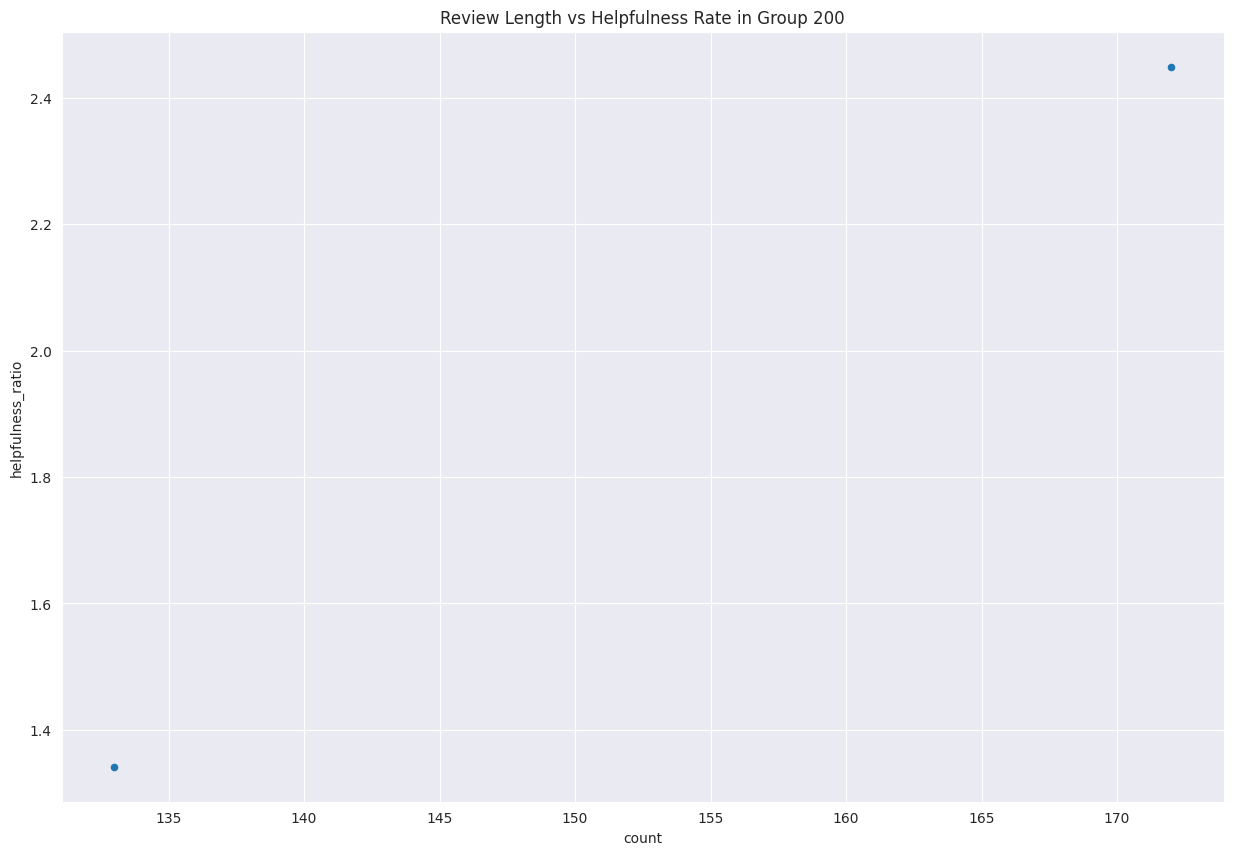

In [17]:
#random select 3000 rows of words_df and convert it to pandas dataframe
df_camp = words_df.sample(withReplacement = False, fraction = 3000/words_df.count(), seed = 42)
df_camp.show(5)

# words_df to pandas dataframe
words_df_pd = df_camp.toPandas()

#scatter plot of count vs helpfulness ratio
import matplotlib.pyplot as plt
plt.scatter(words_df_pd['count'], words_df_pd['helpfulness_ratio'], alpha=0.2)
plt.xlabel('Number of positive words')
plt.ylabel('Helpful score')
plt.show()

# Create 5 bins of positive_words
groups = [0, 10, 20, 50, 75, 100, 200]
words_df_pd['length_bin'] = pd.cut(words_df_pd['count'], bins=groups, labels=[group for group in groups[1:]])

import seaborn as sns
import scipy
# Plot the distribution of positive_words with respect to helpfulness rate
plt.figure(figsize=(15, 10))
sns.boxplot(x='length_bin', y='helpfulness_ratio', data=words_df_pd, palette='rainbow')
plt.title('Review Length Range vs Helpfulness Rate')

for el in groups[1:]:
    dataframe = words_df_pd[words_df_pd['length_bin'] == el]
    corr, pval = scipy.stats.kendalltau(dataframe['count'], dataframe['helpfulness_ratio'])
    print(f'Group number: {el}\nCorrelation Coefficient: {corr}\nP-value: {pval}\n')
    plt.figure(figsize=(15, 10))
    dataframe.plot(kind='scatter', x='count', y='helpfulness_ratio', figsize=(15, 10), title=f'Review Length vs Helpfulness Rate in Group {el}')
    plt.show()

In [18]:
#close spark
spark.stop()